# QOSF Screening
---
### Task: Implement a circuit that returns |01> and |10> with equal probability
- Circuit should only contain rx,ry and cx
- All parameters are randomly chosen
- Find the right set of parameters using gradient descent
- Simulations must be done with sampling: limited no of measurements per iteration and noise

###  The Approach
---

- Consider the two qubits of the required circuit separately
- We know that before applying the CNOT
    - q0 must be in the state $${\frac{|{0}\rangle + |{1}\rangle}{\sqrt{2}}}$$
    - q1 must be in the state $$|{1}\rangle$$

#### Qubit q0
---
Initial state: $$|{0}\rangle$$
On applying RY gate: 
$$
\begin{bmatrix}
cos(\frac{θ}{2}) & -sin(\frac{θ}{2}) \\
sin(\frac{θ}{2}) & cos(\frac{θ}{2})
\end{bmatrix}
\begin{bmatrix}
1\\0
\end{bmatrix}
=
\begin{bmatrix}
cos(\frac{θ}{2}) \\
sin(\frac{θ}{2})
\end{bmatrix}
$$
Here,
$$
sin(\frac{θ}{2}) = cos(\frac{θ}{2})\\
tan(\frac{θ}{2}) = 1\\
$$
We need to minimize
$$
tan(\frac{θ}{2})-1=0
$$

#### Qubit q1
---
Initial state: $$|{0}\rangle$$
We need to get to the state $$|{1}\rangle$$
We know that the Expectation value of $$|{1}\rangle$$ with respect to Pauli Z is -1

$$\langle{1}|Z|{1}\rangle = -1$$
So we arrive at |1> from |0> by applying an RY gate on |0> and minimizing the expectation value of the resulting statevector

---

In [1]:
# importing necessary packages
import pennylane as qml
from pennylane import numpy as np
from qiskit import *
from qiskit.quantum_info import Statevector
import qiskit.providers.aer.noise as noise
from qiskit.visualization import plot_histogram

In [2]:
device = qml.device("default.qubit",wires=1) # setting up a simulator
np.random.seed(41)
def gd(initial,cost): # gradient descent function
    opt = qml.GradientDescentOptimizer(stepsize=0.1)
    steps = 100
    params = initial

    for i in range(steps):
        params = opt.step(cost,params)
    
        if((i+1)%100 == 0):
            print(f"Cost after step {i+1}: {cost(params)}")

    print(f"Optimal Angles: {params}")
    return params

def quantum_circuit(theta,phi): # quantum circuit function
    circ = QuantumCircuit(2)
    circ.ry(theta,0)
    circ.ry(phi,1)
    circ.cx(0,1)
    circ.measure_all()
    return circ

In [3]:
def cost_0(params):
    return ((np.tan(params[0]/2)**2)-1)**2
@qml.qnode(device)
def circuit_0(params):
    qml.RY(params[0], wires=0)
    return qml.probs(wires=0)

def cost_1(x):
    return circuit_1(x)

@qml.qnode(device)
def circuit_1(params):
    qml.RY(params[0], wires=0)
    return qml.expval(qml.PauliZ(0))

shots = [1,10,100,1000]

In [4]:
initial = np.random.rand(1)
print(cost_0(initial))

0.9684383815443279


In [5]:
initial = np.random.rand(1)
print(cost_1(initial))

0.998937775764933


In [6]:
theta = gd(initial,cost_0)[0]

Cost after step 100: 4.930380657631324e-32
Optimal Angles: [1.57079633]


In [7]:
phi = gd(initial,cost_1)[0]

Cost after step 100: -0.9999940775861778
Optimal Angles: [3.13815102]


## Sampling Without Noise
---

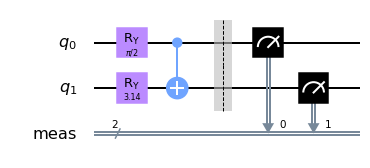

In [8]:
circ = quantum_circuit(theta,phi)
circ.draw('mpl')

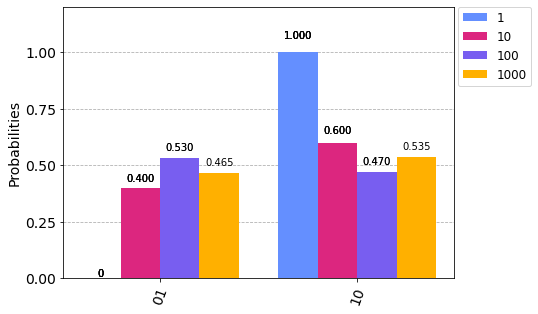

In [9]:
counts_list = []
for shot in shots:
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ,backend=backend,shots=shot)
    counts = job.result().get_counts()
    counts_list.append(counts)
plot_histogram(counts_list, legend =['1', '10', '100', '1000'])

## Sampling with Noise
---

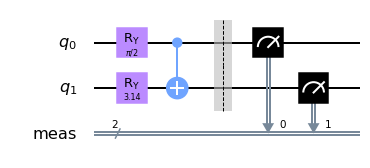

In [10]:
circ = quantum_circuit(theta,phi)
circ.draw('mpl')

In [11]:
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['rx', 'ry'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

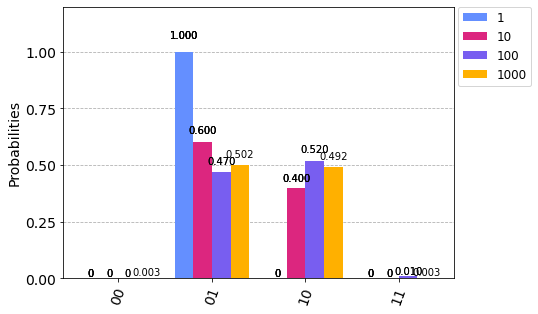

In [12]:
counts_list = []
for shot in shots:
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ,backend=backend,shots=shot,noise_model=noise_model)
    counts = job.result().get_counts()
    counts_list.append(counts)
plot_histogram(counts_list,legend=['1','10','100','1000'])